# LEDITS: Real Image Editing with DDPM Inversion X SEGA 🤗
This Notebook includes and implementation and exploration of the approach introduced in [Real Image Editing with DDPM Inversion and Semantic Guidance](https://editing-images-project.hf.space) using the diffusers library 🧨

**Related links:**

*   [Project Page](https://editing-images-project.hf.space)
*   [ariXv]()
*   [Demo]() 🤗

##Set Up

In [ ]:
!pip install -q transformers diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### [Inversion Utils- copied from DDPM Git repo](https://github.com/inbarhub/DDPM_inversion/blob/9041286b265dc534fa017f842cb345f2b39d6661/ddm_inversion/inversion_utils.py)

In [ ]:
import torch
# import os
from tqdm import tqdm
from PIL import Image, ImageDraw ,ImageFont
# from matplotlib import pyplot as plt
import torchvision.transforms as T
# import os
# import yaml
# import numpy as np


def load_512(image_path, left=0, right=0, top=0, bottom=0, device=None):
    if type(image_path) is str:
        image = np.array(Image.open(image_path).convert('RGB'))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    image = torch.from_numpy(image).float() / 127.5 - 1
    image = image.permute(2, 0, 1).unsqueeze(0).to(device)

    return image



def load_real_image(folder = "data/", img_name = None, idx = 0, img_size=512, device='cuda'):
    from PIL import Image
    from glob import glob
    if img_name is not None:
        path = os.path.join(folder, img_name)
    else:
        path = glob(folder + "*")[idx]

    img = Image.open(path).resize((img_size,
                                    img_size))

    img = pil_to_tensor(img).to(device)

    if img.shape[1]== 4:
        img = img[:,:3,:,:]
    return img

def mu_tilde(model, xt,x0, timestep):
    "mu_tilde(x_t, x_0) DDPM paper eq. 7"
    prev_timestep = timestep - model.scheduler.config.num_train_timesteps // model.scheduler.num_inference_steps
    alpha_prod_t_prev = model.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else model.scheduler.final_alpha_cumprod
    alpha_t = model.scheduler.alphas[timestep]
    beta_t = 1 - alpha_t
    alpha_bar = model.scheduler.alphas_cumprod[timestep]
    return ((alpha_prod_t_prev ** 0.5 * beta_t) / (1-alpha_bar)) * x0 +  ((alpha_t**0.5 *(1-alpha_prod_t_prev)) / (1- alpha_bar))*xt

def sample_xts_from_x0(model, x0, num_inference_steps=50):
    """
    Samples from P(x_1:T|x_0)
    """
    # torch.manual_seed(43256465436)
    alpha_bar = model.scheduler.alphas_cumprod
    sqrt_one_minus_alpha_bar = (1-alpha_bar) ** 0.5
    alphas = model.scheduler.alphas
    betas = 1 - alphas
    variance_noise_shape = (
            num_inference_steps,
            model.unet.in_channels,
            model.unet.sample_size,
            model.unet.sample_size)

    timesteps = model.scheduler.timesteps.to(model.device)
    t_to_idx = {int(v):k for k,v in enumerate(timesteps)}
    xts = torch.zeros(variance_noise_shape).to(x0.device)
    for t in reversed(timesteps):
        idx = t_to_idx[int(t)]
        xts[idx] = x0 * (alpha_bar[t] ** 0.5) + torch.randn_like(x0) * sqrt_one_minus_alpha_bar[t]
    xts = torch.cat([xts, x0 ],dim = 0)

    return xts

def encode_text(model, prompts):
    text_input = model.tokenizer(
        prompts,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        text_encoding = model.text_encoder(text_input.input_ids.to(model.device))[0]
    return text_encoding

def forward_step(model, model_output, timestep, sample):
    next_timestep = min(model.scheduler.config.num_train_timesteps - 2,
                        timestep + model.scheduler.config.num_train_timesteps // model.scheduler.num_inference_steps)

    # 2. compute alphas, betas
    alpha_prod_t = model.scheduler.alphas_cumprod[timestep]
    # alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep] if next_ltimestep >= 0 else self.scheduler.final_alpha_cumprod

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise also called
    # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

    # 5. TODO: simple noising implementatiom
    next_sample = model.scheduler.add_noise(pred_original_sample,
                                    model_output,
                                    torch.LongTensor([next_timestep]))
    return next_sample


def get_variance(model, timestep): #, prev_timestep):
    prev_timestep = timestep - model.scheduler.config.num_train_timesteps // model.scheduler.num_inference_steps
    alpha_prod_t = model.scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = model.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else model.scheduler.final_alpha_cumprod
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
    return variance

def inversion_forward_process(model, x0,
                            etas = None,
                            prog_bar = False,
                            prompt = "",
                            cfg_scale = 3.5,
                            num_inference_steps=50, eps = None):

    if not prompt=="":
        text_embeddings = encode_text(model, prompt)
    uncond_embedding = encode_text(model, "")
    timesteps = model.scheduler.timesteps.to(model.device)
    variance_noise_shape = (
        num_inference_steps,
        model.unet.in_channels,
        model.unet.sample_size,
        model.unet.sample_size)
    if etas is None or (type(etas) in [int, float] and etas == 0):
        eta_is_zero = True
        zs = None
    else:
        eta_is_zero = False
        if type(etas) in [int, float]: etas = [etas]*model.scheduler.num_inference_steps
        xts = sample_xts_from_x0(model, x0, num_inference_steps=num_inference_steps)
        alpha_bar = model.scheduler.alphas_cumprod
        zs = torch.zeros(size=variance_noise_shape, device=model.device)

    t_to_idx = {int(v):k for k,v in enumerate(timesteps)}
    xt = x0
    op = tqdm(reversed(timesteps)) if prog_bar else reversed(timesteps)

    for t in op:
        idx = t_to_idx[int(t)]
        # 1. predict noise residual
        if not eta_is_zero:
            xt = xts[idx][None]

        with torch.no_grad():
            out = model.unet.forward(xt, timestep =  t, encoder_hidden_states = uncond_embedding)
            if not prompt=="":
                cond_out = model.unet.forward(xt, timestep=t, encoder_hidden_states = text_embeddings)

        if not prompt=="":
            ## classifier free guidance
            noise_pred = out.sample + cfg_scale * (cond_out.sample - out.sample)
        else:
            noise_pred = out.sample

        if eta_is_zero:
            # 2. compute more noisy image and set x_t -> x_t+1
            xt = forward_step(model, noise_pred, t, xt)

        else:
            xtm1 =  xts[idx+1][None]
            # pred of x0
            pred_original_sample = (xt - (1-alpha_bar[t])  ** 0.5 * noise_pred ) / alpha_bar[t] ** 0.5

            # direction to xt
            prev_timestep = t - model.scheduler.config.num_train_timesteps // model.scheduler.num_inference_steps
            alpha_prod_t_prev = model.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else model.scheduler.final_alpha_cumprod

            variance = get_variance(model, t)
            pred_sample_direction = (1 - alpha_prod_t_prev - etas[idx] * variance ) ** (0.5) * noise_pred

            mu_xt = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

            z = (xtm1 - mu_xt ) / ( etas[idx] * variance ** 0.5 )
            zs[idx] = z

            # correction to avoid error accumulation
            xtm1 = mu_xt + ( etas[idx] * variance ** 0.5 )*z
            xts[idx+1] = xtm1

    if not zs is None:
        zs[-1] = torch.zeros_like(zs[-1])

    return xt, zs, xts


def reverse_step(model, model_output, timestep, sample, eta = 0, variance_noise=None):
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - model.scheduler.config.num_train_timesteps // model.scheduler.num_inference_steps
    # 2. compute alphas, betas
    alpha_prod_t = model.scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = model.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else model.scheduler.final_alpha_cumprod
    beta_prod_t = 1 - alpha_prod_t
    # 3. compute predicted original sample from predicted noise also called
    # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
    # 5. compute variance: "sigma_t(η)" -> see formula (16)
    # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
    # variance = self.scheduler._get_variance(timestep, prev_timestep)
    variance = get_variance(model, timestep) #, prev_timestep)
    std_dev_t = eta * variance ** (0.5)
    # Take care of asymetric reverse process (asyrp)
    model_output_direction = model_output
    # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    # pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * model_output_direction
    pred_sample_direction = (1 - alpha_prod_t_prev - eta * variance) ** (0.5) * model_output_direction
    # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
    # 8. Add noice if eta > 0
    if eta > 0:
        if variance_noise is None:
            variance_noise = torch.randn(model_output.shape, device=model.device)
        sigma_z =  eta * variance ** (0.5) * variance_noise
        prev_sample = prev_sample + sigma_z

    return prev_sample

def inversion_reverse_process(model,
                    xT,
                    etas = 0,
                    prompts = "",
                    cfg_scales = None,
                    prog_bar = False,
                    zs = None,
                    controller=None,
                    asyrp = False):

    batch_size = len(prompts)

    cfg_scales_tensor = torch.Tensor(cfg_scales).view(-1,1,1,1).to(model.device)

    text_embeddings = encode_text(model, prompts)
    uncond_embedding = encode_text(model, [""] * batch_size)

    if etas is None: etas = 0
    if type(etas) in [int, float]: etas = [etas]*model.scheduler.num_inference_steps
    assert len(etas) == model.scheduler.num_inference_steps
    timesteps = model.scheduler.timesteps.to(model.device)

    xt = xT.expand(batch_size, -1, -1, -1)
    op = tqdm(timesteps[-zs.shape[0]:]) if prog_bar else timesteps[-zs.shape[0]:]

    t_to_idx = {int(v):k for k,v in enumerate(timesteps[-zs.shape[0]:])}

    for t in op:
        idx = t_to_idx[int(t)]
        ## Unconditional embedding
        with torch.no_grad():
            uncond_out = model.unet.forward(xt, timestep =  t,
                                            encoder_hidden_states = uncond_embedding)

            ## Conditional embedding
        if prompts:
            with torch.no_grad():
                cond_out = model.unet.forward(xt, timestep =  t,
                                                encoder_hidden_states = text_embeddings)


        z = zs[idx] if not zs is None else None
        z = z.expand(batch_size, -1, -1, -1)
        if prompts:
            ## classifier free guidance
            noise_pred = uncond_out.sample + cfg_scales_tensor * (cond_out.sample - uncond_out.sample)
        else:
            noise_pred = uncond_out.sample
        # 2. compute less noisy image and set x_t -> x_t-1
        xt = reverse_step(model, noise_pred, t, xt, eta = etas[idx], variance_noise = z)
        if controller is not None:
            xt = controller.step_callback(xt)
    return xt, zs


In [ ]:
import PIL
from PIL import Image, ImageDraw ,ImageFont
from matplotlib import pyplot as plt
import torchvision.transforms as T
import os
import torch
import yaml

def show_torch_img(img):
    img = to_np_image(img)
    plt.imshow(img)
    plt.axis("off")

def to_np_image(all_images):
    all_images = (all_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()[0]
    return all_images

def tensor_to_pil(tensor_imgs):
    if type(tensor_imgs) == list:
        tensor_imgs = torch.cat(tensor_imgs)
    tensor_imgs = (tensor_imgs / 2 + 0.5).clamp(0, 1)
    to_pil = T.ToPILImage()
    pil_imgs = [to_pil(img) for img in tensor_imgs]
    return pil_imgs

def pil_to_tensor(pil_imgs):
    to_torch = T.ToTensor()
    if type(pil_imgs) == PIL.Image.Image:
        tensor_imgs = to_torch(pil_imgs).unsqueeze(0)*2-1
    elif type(pil_imgs) == list:
        tensor_imgs = torch.cat([to_torch(pil_imgs).unsqueeze(0)*2-1 for img in pil_imgs]).to(device)
    else:
        raise Exception("Input need to be PIL.Image or list of PIL.Image")
    return tensor_imgs


## TODO implement this
# n = 10
# num_rows = 4
# num_col = n // num_rows
# num_col  = num_col + 1 if n % num_rows else num_col
# num_col
def add_margin(pil_img, top = 0, right = 0, bottom = 0,
                    left = 0, color = (255,255,255)):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)

    result.paste(pil_img, (left, top))
    return result

def image_grid(imgs, rows = 1, cols = None,
                    size = None,
                   titles = None, text_pos = (0, 0)):
    if type(imgs) == list and type(imgs[0]) == torch.Tensor:
        imgs = torch.cat(imgs)
    if type(imgs) == torch.Tensor:
        imgs = tensor_to_pil(imgs)

    if not size is None:
        imgs = [img.resize((size,size)) for img in imgs]
    if cols is None:
        cols = len(imgs)
    assert len(imgs) >= rows*cols

    top=20
    w, h = imgs[0].size
    delta = 0
    if len(imgs)> 1 and not imgs[1].size[1] == h:
        delta = top
        h = imgs[1].size[1]
    if not titles is  None:
        font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeMono.ttf",
                                    size = 20, encoding="unic")
        h = top + h
    grid = Image.new('RGB', size=(cols*w, rows*h+delta))
    for i, img in enumerate(imgs):

        if not titles is  None:
            img = add_margin(img, top = top, bottom = 0,left=0)
            draw = ImageDraw.Draw(img)
            draw.text(text_pos, titles[i],(0,0,0),
            font = font)
        if not delta == 0 and i > 0:
           grid.paste(img, box=(i%cols*w, i//cols*h+delta))
        else:
            grid.paste(img, box=(i%cols*w, i//cols*h))

    return grid


"""
input_folder - dataset folder
"""
def load_dataset(input_folder):
    # full_file_names = glob.glob(input_folder)
    # class_names = [x[0] for x in os.walk(input_folder)]
    class_names = next(os.walk(input_folder))[1]
    class_names[:] = [d for d in class_names if not d[0] == '.']
    file_names=[]
    for class_name in class_names:
        cur_path = os.path.join(input_folder, class_name)
        filenames = next(os.walk(cur_path), (None, None, []))[2]
        filenames = [f for f in filenames if not f[0] == '.']
        file_names.append(filenames)
    return class_names, file_names


def dataset_from_yaml(yaml_location):
    with open(yaml_location, 'r') as stream:
        data_loaded = yaml.safe_load(stream)

    return data_loaded

###DDPM invert and sample

In [ ]:
def invert(x0:torch.FloatTensor, prompt_src:str ="", num_inference_steps=100, cfg_scale_src = 3.5, eta = 1):

  #  inverts a real image according to Algorihm 1 in https://arxiv.org/pdf/2304.06140.pdf,
  #  based on the code in https://github.com/inbarhub/DDPM_inversion

  #  returns wt, zs, wts:
  #  wt - inverted latent
  #  wts - intermediate inverted latents
  #  zs - noise maps

  sd_pipe.scheduler.set_timesteps(num_diffusion_steps)

  # vae encode image
  with autocast("cuda"), inference_mode():
      w0 = (sd_pipe.vae.encode(x0).latent_dist.mode() * 0.18215).float()

  # find Zs and wts - forward process
  wt, zs, wts = inversion_forward_process(sd_pipe, w0, etas=eta, prompt=prompt_src, cfg_scale=cfg_scale_src, prog_bar=True, num_inference_steps=num_diffusion_steps)
  return zs, wts



def sample(zs, wts, prompt_tar="", cfg_scale_tar=15, skip=36, eta = 1):

    # reverse process (via Zs and wT)
    w0, _ = inversion_reverse_process(sd_pipe, xT=wts[skip], etas=eta, prompts=[prompt_tar], cfg_scales=[cfg_scale_tar], prog_bar=True, zs=zs[skip:])

    # vae decode image
    with autocast("cuda"), inference_mode():
        x0_dec = sd_pipe.vae.decode(1 / 0.18215 * w0).sample
    if x0_dec.dim()<4:
        x0_dec = x0_dec[None,:,:,:]
    img = image_grid(x0_dec)
    return img



In [ ]:
def foo(a:str = "l") -> int:
  print("a")
foo(3)

a


###**Modifications to the SEGA pipeline call method**:


*   3 new args:
        use_ddpm: bool = False,
        #wts are the intermidates latents output of ddpm
        wts: Optional[List[torch.Tensor]] = None,
        # zs are the intermiate noise maps output of ddpm
        zs: Optional[List[torch.Tensor]] = None
*   timesteps offset when `use_ddpm == True`:
    denoising loop starts from: `timesteps[-zs[skip:].shape[0]]`

*   step update x_t->x_t-1 when `use_ddpm == True` is done according to the `reverse_step` function in the [DDPM implmentation](https://github.com/inbarhub/DDPM_inversion/blob/9041286b265dc534fa017f842cb345f2b39d6661/ddm_inversion/inversion_utils.py)





### Modified diffusers 🧨 SEGA pipeline

In [ ]:

import inspect
import warnings
from itertools import repeat
from typing import Callable, List, Optional, Union

import torch
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer

from diffusers.image_processor import VaeImageProcessor
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import logging, randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
# from . import SemanticStableDiffusionPipelineOutput


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


class SemanticStableDiffusionPipeline(DiffusionPipeline):
    r"""
    Pipeline for text-to-image generation with latent editing.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)

    This model builds on the implementation of ['StableDiffusionPipeline']

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latens. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`Q16SafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details.
        feature_extractor ([`CLIPImageProcessor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """

    _optional_components = ["safety_checker", "feature_extractor"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: KarrasDiffusionSchedulers,
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.run_safety_checker
    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is None:
            has_nsfw_concept = None
        else:
            if torch.is_tensor(image):
                feature_extractor_input = self.image_processor.postprocess(image, output_type="pil")
            else:
                feature_extractor_input = self.image_processor.numpy_to_pil(image)
            safety_checker_input = self.feature_extractor(feature_extractor_input, return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        return image, has_nsfw_concept

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.decode_latents
    def decode_latents(self, latents):
        warnings.warn(
            "The decode_latents method is deprecated and will be removed in a future version. Please"
            " use VaeImageProcessor instead",
            FutureWarning,
        )
        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.decode(latents, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.check_inputs
    def check_inputs(
        self,
        prompt,
        height,
        width,
        callback_steps,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
    ):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_latents
    def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype, device, generator, latents=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
        else:
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: int = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        editing_prompt: Optional[Union[str, List[str]]] = None,
        editing_prompt_embeddings: Optional[torch.Tensor] = None,
        reverse_editing_direction: Optional[Union[bool, List[bool]]] = False,
        edit_guidance_scale: Optional[Union[float, List[float]]] = 5,
        edit_warmup_steps: Optional[Union[int, List[int]]] = 10,
        edit_cooldown_steps: Optional[Union[int, List[int]]] = None,
        edit_threshold: Optional[Union[float, List[float]]] = 0.9,
        edit_momentum_scale: Optional[float] = 0.1,
        edit_mom_beta: Optional[float] = 0.4,
        edit_weights: Optional[List[float]] = None,
        sem_guidance: Optional[List[torch.Tensor]] = None,

        # DDPM additions
        use_ddpm: bool = False,
        wts: Optional[List[torch.Tensor]] = None,
        zs: Optional[List[torch.Tensor]] = None
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            editing_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to use for Semantic guidance. Semantic guidance is disabled by setting
                `editing_prompt = None`. Guidance direction of prompt should be specified via
                `reverse_editing_direction`.
            editing_prompt_embeddings (`torch.Tensor>`, *optional*):
                Pre-computed embeddings to use for semantic guidance. Guidance direction of embedding should be
                specified via `reverse_editing_direction`.
            reverse_editing_direction (`bool` or `List[bool]`, *optional*, defaults to `False`):
                Whether the corresponding prompt in `editing_prompt` should be increased or decreased.
            edit_guidance_scale (`float` or `List[float]`, *optional*, defaults to 5):
                Guidance scale for semantic guidance. If provided as list values should correspond to `editing_prompt`.
                `edit_guidance_scale` is defined as `s_e` of equation 6 of [SEGA
                Paper](https://arxiv.org/pdf/2301.12247.pdf).
            edit_warmup_steps (`float` or `List[float]`, *optional*, defaults to 10):
                Number of diffusion steps (for each prompt) for which semantic guidance will not be applied. Momentum
                will still be calculated for those steps and applied once all warmup periods are over.
                `edit_warmup_steps` is defined as `delta` (δ) of [SEGA Paper](https://arxiv.org/pdf/2301.12247.pdf).
            edit_cooldown_steps (`float` or `List[float]`, *optional*, defaults to `None`):
                Number of diffusion steps (for each prompt) after which semantic guidance will no longer be applied.
            edit_threshold (`float` or `List[float]`, *optional*, defaults to 0.9):
                Threshold of semantic guidance.
            edit_momentum_scale (`float`, *optional*, defaults to 0.1):
                Scale of the momentum to be added to the semantic guidance at each diffusion step. If set to 0.0
                momentum will be disabled. Momentum is already built up during warmup, i.e. for diffusion steps smaller
                than `sld_warmup_steps`. Momentum will only be added to latent guidance once all warmup periods are
                finished. `edit_momentum_scale` is defined as `s_m` of equation 7 of [SEGA
                Paper](https://arxiv.org/pdf/2301.12247.pdf).
            edit_mom_beta (`float`, *optional*, defaults to 0.4):
                Defines how semantic guidance momentum builds up. `edit_mom_beta` indicates how much of the previous
                momentum will be kept. Momentum is already built up during warmup, i.e. for diffusion steps smaller
                than `edit_warmup_steps`. `edit_mom_beta` is defined as `beta_m` (β) of equation 8 of [SEGA
                Paper](https://arxiv.org/pdf/2301.12247.pdf).
            edit_weights (`List[float]`, *optional*, defaults to `None`):
                Indicates how much each individual concept should influence the overall guidance. If no weights are
                provided all concepts are applied equally. `edit_mom_beta` is defined as `g_i` of equation 9 of [SEGA
                Paper](https://arxiv.org/pdf/2301.12247.pdf).
            sem_guidance (`List[torch.Tensor]`, *optional*):
                List of pre-generated guidance vectors to be applied at generation. Length of the list has to
                correspond to `num_inference_steps`.

        Returns:
            [`~pipelines.semantic_stable_diffusion.SemanticStableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.semantic_stable_diffusion.SemanticStableDiffusionPipelineOutput`] if `return_dict` is True,
            otherwise a `tuple. When returning a tuple, the first element is a list with the generated images, and the
            second element is a list of `bool`s denoting whether the corresponding generated image likely represents
            "not-safe-for-work" (nsfw) content, according to the `safety_checker`.
        """
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(prompt, height, width, callback_steps)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)

        if editing_prompt:
            enable_edit_guidance = True
            if isinstance(editing_prompt, str):
                editing_prompt = [editing_prompt]
            enabled_editing_prompts = len(editing_prompt)
        elif editing_prompt_embeddings is not None:
            enable_edit_guidance = True
            enabled_editing_prompts = editing_prompt_embeddings.shape[0]
        else:
            enabled_editing_prompts = 0
            enable_edit_guidance = False

        # get prompt text embeddings
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids

        if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
            removed_text = self.tokenizer.batch_decode(text_input_ids[:, self.tokenizer.model_max_length :])
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )
            text_input_ids = text_input_ids[:, : self.tokenizer.model_max_length]
        text_embeddings = self.text_encoder(text_input_ids.to(self.device))[0]

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = text_embeddings.shape
        text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
        text_embeddings = text_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

        if enable_edit_guidance:
            # get safety text embeddings
            if editing_prompt_embeddings is None:
                edit_concepts_input = self.tokenizer(
                    [x for item in editing_prompt for x in repeat(item, batch_size)],
                    padding="max_length",
                    max_length=self.tokenizer.model_max_length,
                    return_tensors="pt",
                )

                edit_concepts_input_ids = edit_concepts_input.input_ids

                if edit_concepts_input_ids.shape[-1] > self.tokenizer.model_max_length:
                    removed_text = self.tokenizer.batch_decode(
                        edit_concepts_input_ids[:, self.tokenizer.model_max_length :]
                    )
                    logger.warning(
                        "The following part of your input was truncated because CLIP can only handle sequences up to"
                        f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                    )
                    edit_concepts_input_ids = edit_concepts_input_ids[:, : self.tokenizer.model_max_length]
                edit_concepts = self.text_encoder(edit_concepts_input_ids.to(self.device))[0]
            else:
                edit_concepts = editing_prompt_embeddings.to(self.device).repeat(batch_size, 1, 1)

            # duplicate text embeddings for each generation per prompt, using mps friendly method
            bs_embed_edit, seq_len_edit, _ = edit_concepts.shape
            edit_concepts = edit_concepts.repeat(1, num_images_per_prompt, 1)
            edit_concepts = edit_concepts.view(bs_embed_edit * num_images_per_prompt, seq_len_edit, -1)

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance

        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""]
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = uncond_embeddings.repeat(batch_size, num_images_per_prompt, 1)
            uncond_embeddings = uncond_embeddings.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            if enable_edit_guidance:
                text_embeddings = torch.cat([uncond_embeddings, text_embeddings, edit_concepts])
            else:
                text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        # get the initial random noise unless the user supplied it

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=self.device)
        timesteps = self.scheduler.timesteps
        if use_ddpm:
          t_to_idx = {int(v):k for k,v in enumerate(timesteps[-zs.shape[0]:])}
          timesteps = timesteps[-zs.shape[0]:]

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            self.device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs.
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # Initialize edit_momentum to None
        edit_momentum = None

        self.uncond_estimates = None
        self.text_estimates = None
        self.edit_estimates = None
        self.sem_guidance = None

        for i, t in enumerate(self.progress_bar(timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                torch.cat([latents] * (2 + enabled_editing_prompts)) if do_classifier_free_guidance else latents
            )
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_out = noise_pred.chunk(2 + enabled_editing_prompts)  # [b,4, 64, 64]
                noise_pred_uncond, noise_pred_text = noise_pred_out[0], noise_pred_out[1]
                noise_pred_edit_concepts = noise_pred_out[2:]

                # default text guidance
                noise_guidance = guidance_scale * (noise_pred_text - noise_pred_uncond)
                # noise_guidance = (noise_pred_text - noise_pred_edit_concepts[0])

                if self.uncond_estimates is None:
                    self.uncond_estimates = torch.zeros((num_inference_steps + 1, *noise_pred_uncond.shape))
                self.uncond_estimates[i] = noise_pred_uncond.detach().cpu()

                if self.text_estimates is None:
                    self.text_estimates = torch.zeros((num_inference_steps + 1, *noise_pred_text.shape))
                self.text_estimates[i] = noise_pred_text.detach().cpu()

                if self.edit_estimates is None and enable_edit_guidance:
                    self.edit_estimates = torch.zeros(
                        (num_inference_steps + 1, len(noise_pred_edit_concepts), *noise_pred_edit_concepts[0].shape)
                    )

                if self.sem_guidance is None:
                    self.sem_guidance = torch.zeros((num_inference_steps + 1, *noise_pred_text.shape))

                if edit_momentum is None:
                    edit_momentum = torch.zeros_like(noise_guidance)

                if enable_edit_guidance:
                    concept_weights = torch.zeros(
                        (len(noise_pred_edit_concepts), noise_guidance.shape[0]),
                        device=self.device,
                        dtype=noise_guidance.dtype,
                    )
                    noise_guidance_edit = torch.zeros(
                        (len(noise_pred_edit_concepts), *noise_guidance.shape),
                        device=self.device,
                        dtype=noise_guidance.dtype,
                    )
                    # noise_guidance_edit = torch.zeros_like(noise_guidance)
                    warmup_inds = []
                    for c, noise_pred_edit_concept in enumerate(noise_pred_edit_concepts):
                        self.edit_estimates[i, c] = noise_pred_edit_concept
                        if isinstance(edit_guidance_scale, list):
                            edit_guidance_scale_c = edit_guidance_scale[c]
                        else:
                            edit_guidance_scale_c = edit_guidance_scale

                        if isinstance(edit_threshold, list):
                            edit_threshold_c = edit_threshold[c]
                        else:
                            edit_threshold_c = edit_threshold
                        if isinstance(reverse_editing_direction, list):
                            reverse_editing_direction_c = reverse_editing_direction[c]
                        else:
                            reverse_editing_direction_c = reverse_editing_direction
                        if edit_weights:
                            edit_weight_c = edit_weights[c]
                        else:
                            edit_weight_c = 1.0
                        if isinstance(edit_warmup_steps, list):
                            edit_warmup_steps_c = edit_warmup_steps[c]
                        else:
                            edit_warmup_steps_c = edit_warmup_steps

                        if isinstance(edit_cooldown_steps, list):
                            edit_cooldown_steps_c = edit_cooldown_steps[c]
                        elif edit_cooldown_steps is None:
                            edit_cooldown_steps_c = i + 1
                        else:
                            edit_cooldown_steps_c = edit_cooldown_steps
                        if i >= edit_warmup_steps_c:
                            warmup_inds.append(c)
                        if i >= edit_cooldown_steps_c:
                            noise_guidance_edit[c, :, :, :, :] = torch.zeros_like(noise_pred_edit_concept)
                            continue

                        noise_guidance_edit_tmp = noise_pred_edit_concept - noise_pred_uncond
                        # tmp_weights = (noise_pred_text - noise_pred_edit_concept).sum(dim=(1, 2, 3))
                        tmp_weights = (noise_guidance - noise_pred_edit_concept).sum(dim=(1, 2, 3))

                        tmp_weights = torch.full_like(tmp_weights, edit_weight_c)  # * (1 / enabled_editing_prompts)
                        if reverse_editing_direction_c:
                            noise_guidance_edit_tmp = noise_guidance_edit_tmp * -1
                        concept_weights[c, :] = tmp_weights

                        noise_guidance_edit_tmp = noise_guidance_edit_tmp * edit_guidance_scale_c

                        # torch.quantile function expects float32
                        if noise_guidance_edit_tmp.dtype == torch.float32:
                            tmp = torch.quantile(
                                torch.abs(noise_guidance_edit_tmp).flatten(start_dim=2),
                                edit_threshold_c,
                                dim=2,
                                keepdim=False,
                            )
                        else:
                            tmp = torch.quantile(
                                torch.abs(noise_guidance_edit_tmp).flatten(start_dim=2).to(torch.float32),
                                edit_threshold_c,
                                dim=2,
                                keepdim=False,
                            ).to(noise_guidance_edit_tmp.dtype)

                        noise_guidance_edit_tmp = torch.where(
                            torch.abs(noise_guidance_edit_tmp) >= tmp[:, :, None, None],
                            noise_guidance_edit_tmp,
                            torch.zeros_like(noise_guidance_edit_tmp),
                        )
                        noise_guidance_edit[c, :, :, :, :] = noise_guidance_edit_tmp

                        # noise_guidance_edit = noise_guidance_edit + noise_guidance_edit_tmp

                    warmup_inds = torch.tensor(warmup_inds).to(self.device)
                    if len(noise_pred_edit_concepts) > warmup_inds.shape[0] > 0:
                        concept_weights = concept_weights.to("cpu")  # Offload to cpu
                        noise_guidance_edit = noise_guidance_edit.to("cpu")

                        concept_weights_tmp = torch.index_select(concept_weights.to(self.device), 0, warmup_inds)
                        concept_weights_tmp = torch.where(
                            concept_weights_tmp < 0, torch.zeros_like(concept_weights_tmp), concept_weights_tmp
                        )
                        concept_weights_tmp = concept_weights_tmp / concept_weights_tmp.sum(dim=0)
                        # concept_weights_tmp = torch.nan_to_num(concept_weights_tmp)

                        noise_guidance_edit_tmp = torch.index_select(
                            noise_guidance_edit.to(self.device), 0, warmup_inds
                        )
                        noise_guidance_edit_tmp = torch.einsum(
                            "cb,cbijk->bijk", concept_weights_tmp, noise_guidance_edit_tmp
                        )
                        noise_guidance_edit_tmp = noise_guidance_edit_tmp
                        noise_guidance = noise_guidance + noise_guidance_edit_tmp

                        self.sem_guidance[i] = noise_guidance_edit_tmp.detach().cpu()

                        del noise_guidance_edit_tmp
                        del concept_weights_tmp
                        concept_weights = concept_weights.to(self.device)
                        noise_guidance_edit = noise_guidance_edit.to(self.device)

                    concept_weights = torch.where(
                        concept_weights < 0, torch.zeros_like(concept_weights), concept_weights
                    )

                    concept_weights = torch.nan_to_num(concept_weights)

                    noise_guidance_edit = torch.einsum("cb,cbijk->bijk", concept_weights, noise_guidance_edit)

                    noise_guidance_edit = noise_guidance_edit + edit_momentum_scale * edit_momentum

                    edit_momentum = edit_mom_beta * edit_momentum + (1 - edit_mom_beta) * noise_guidance_edit

                    if warmup_inds.shape[0] == len(noise_pred_edit_concepts):
                        noise_guidance = noise_guidance + noise_guidance_edit
                        self.sem_guidance[i] = noise_guidance_edit.detach().cpu()

                if sem_guidance is not None:
                    edit_guidance = sem_guidance[i].to(self.device)
                    noise_guidance = noise_guidance + edit_guidance

                noise_pred = noise_pred_uncond + noise_guidance
            ## ddpm ###########################################################
            if use_ddpm:

              idx = t_to_idx[int(t)]
              z = zs[idx] if not zs is None else None

              # 1. get previous step value (=t-1)
              prev_timestep = t - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
              # 2. compute alphas, betas
              alpha_prod_t = self.scheduler.alphas_cumprod[t]
              alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
              beta_prod_t = 1 - alpha_prod_t

              # 3. compute predicted original sample from predicted noise also called
              # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
              pred_original_sample = (latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)


              # 5. compute variance: "sigma_t(η)" -> see formula (16)
              # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
              # variance = self.scheduler._get_variance(timestep, prev_timestep)
              # variance = get_variance(model, t) #, prev_timestep)
              beta_prod_t_prev = 1 - alpha_prod_t_prev
              variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)



              std_dev_t = eta * variance ** (0.5)
              # Take care of asymetric reverse process (asyrp)
              noise_pred_direction = noise_pred

              # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
              # pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * model_output_direction
              pred_sample_direction = (1 - alpha_prod_t_prev - eta * variance) ** (0.5) * noise_pred_direction

              # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
              prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
              # 8. Add noice if eta > 0
              if eta > 0:
                  if z is None:
                      z = torch.randn(noise_pred.shape, device=self.device)
                  sigma_z =  eta * variance ** (0.5) * z
                  latents = prev_sample + sigma_z

            ## ddpm ##########################################################
                # compute the previous noisy sample x_t -> x_t-1
            else: #if not use_ddpm:
              latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if callback is not None and i % callback_steps == 0:
                callback(i, t, latents)

        # 8. Post-processing
        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            image, has_nsfw_concept = self.run_safety_checker(image, self.device, text_embeddings.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

### Load pipelines and put it all together

In [ ]:
import torch
import numpy as np
import requests
import random
from io import BytesIO
from diffusers import StableDiffusionPipeline
from diffusers import DDIMScheduler
from torch import autocast, inference_mode
import re

# load pipelines
sd_model_id = "runwayml/stable-diffusion-v1-5"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sd_pipe = StableDiffusionPipeline.from_pretrained(sd_model_id).to(device)
sd_pipe.scheduler = DDIMScheduler.from_config(sd_model_id, subfolder = "scheduler")
sega_pipe = SemanticStableDiffusionPipeline.from_pretrained(sd_model_id).to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:219: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
def edit(wts, zs,
            tar_prompt = "",
            steps = 100,
            skip = 36,
            tar_cfg_scale =15,
            edit_concept = "",
            guidnace_scale = 7,
            warmup = 1,
            neg_guidance=False,
            threshold=0.95

   ):

    # SEGA
    # parse concepts and neg guidance
    editing_args = dict(
    editing_prompt = edit_concept,
    reverse_editing_direction = neg_guidance,
    edit_warmup_steps=warmup,
    edit_guidance_scale=guidnace_scale,
    edit_threshold=threshold,
    edit_momentum_scale=0.5,
    edit_mom_beta=0.6,
    eta=1,
  )
    latnets = wts[skip].expand(1, -1, -1, -1)
    sega_out = sega_pipe(prompt=tar_prompt, latents=latnets, guidance_scale = tar_cfg_scale,
                        num_images_per_prompt=1,
                        num_inference_steps=steps,
                        use_ddpm=True,  wts=wts, zs=zs[skip:], **editing_args)
    return sega_out.images[0]

## 🎨 **Getting Started: Overview and Tips** 🎨


1.   choose an image
2.   `invert`
  - **input** =
  ```
  invert(image, num_diffusion_steps, source_guidance_scale`) -> zs, wts
  ```
  - We reccomend using the deault values for ` num_diffusion_steps = 100, source_guidance_scale = 3.5`as used in the DDPM inversion paper.
  - **output** = `zs, wts` - `zs` are the noise maps associated the image, and `wts` are the intermidated inverted latents.  

3.  `edit`
  - **input** =
    ```
            edit(wts, zs,
            target_prompt,
            num_diffusion_steps,
            skip_steps,
            target_guidance_scale,
            edit_concepts,
            edit_guidnace_scales,
            warmup_steps,
            reverse_editing,
            thresholds) -> sega_edited_image
    ```
    - `edit_concepts` represents the list of concepts to add/reomve with SEGA
      `reverse_editing` is a list of booleans corresponding to each concept in the `edit_concepts` list. if you wish to remove a concept set the correspoding value in the` reverse_editing` list to `True`.
  

**How to get started?** 🖌
1.  While the best approach depends on your editing objective and source image,  we can layout a few guiding tips to use as a starting point -

1. **DDPM** is usually more suited for scene/style changes and major subject changes (for example ) while **SEGA** allows for more fine grained control, changes are more delicate, more suited for adding details (for example facial expressions and attributes, subtle style modifications, object adding/removing)
2. The more you describe the scene in the target prompt (both the parts and details you wish to keep the same and those you wish to change), the better the result
3. **Combining DDPM Edit with SEGA -**
Try dividing your editing objective to more significant scene/style/subject changes and detail adding/removing and more moderate changes. Then describe the major changes in a detailed target prompt and add the more fine grained details as SEGA concepts.
4. **Reconstruction:** Using an empty source prompt + target prompt will lead to a perfect reconstruction


**Hyperparameter Tuning Help:**
* To experiement with reconstruction, set `reconstruct = True` and use identical prompts for `source_prompt` and `target_prompt`
* To get pure ddpm edit results, set the `target_prompt` to be the desired edit output, and set `reconstruct = True`
* DDPM authors suggest to play around with `skip` in the range `[0,40]` and `cfg_tar` in the range `[7,18]`
- **Fidelity vs Creativity**:
    
    Bigger values → more fidelity, smaller values → more creativity
    
    1. `skip_steps`
    2. `warmup_steps` (SEGA)
    3. `thresholds`  (SEGA)
    
    Bigger values → more creativity, smaller values → more fidelity
    
    1. `target_gudiance_scale`
    2. `edit_guidance_scales` (SEGA)


**For further intuition and explanations on the effect of each parameter we refer you the original papers:**
  [An Edit Friendly DDPM Noise Space:
                        Inversion and Manipulations](arxiv.org/pdf/2304.06140.pdf),
  [SEGA: Instructing Diffusion using Semantic Dimensions](arxiv.org/pdf/2301.12247.pdf)




## **Run the show** 🏃🧨

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
input_image = "./example_images/flower_field.jpg" #@param

source_prompt  ="" #@param
target_prompt ="oil painting" #@param
num_diffusion_steps =100 #@param
source_guidance_scale = 3.5 #@param
reconstruct = True #@param
skip_steps =36 #@param
target_guidance_scale=20 #@param

# SEGA only params
edit_concepts=["red flowers", "wheat"]#@param
edit_guidance_scales=[7,15] #@param
warmup_steps=[1,1] #@param
reverse_editing=[True, False] #@param
thresholds = [ 0.95,0.95] #@param



In [ ]:
# uncomment for reproducabilty
import torch
seed = 36478574352 #@param
# torch.manual_seed(seed)

In [ ]:
# Invert with ddpm
x0 = load_512(input_image, device=device)
# noise maps and latents
zs, wts = invert(x0 =x0 , prompt_src=source_prompt, num_inference_steps=num_diffusion_steps, cfg_scale_src=source_guidance_scale)
if reconstruct:
  ddpm_out_img = sample(zs, wts, prompt_tar=target_prompt, skip=skip_steps, cfg_scale_tar=target_guidance_scale)

<ipython-input-3-bd4b35970aa1>:144: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  model.unet.in_channels,
<ipython-input-3-bd4b35970aa1>:75: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  model.unet.in_channels,
100%|██████████| 64/64 [00:30<00:00,  2.12it/s]


In [ ]:
# edit with the pre-computed latents and noise maps
sega_ddpm_edited_img =edit(wts, zs,
            tar_prompt = target_prompt,
            steps = num_diffusion_steps,
            skip = skip_steps,
            tar_cfg_scale =target_guidance_scale,
            edit_concept = edit_concepts,
            guidnace_scale = edit_guidance_scales,
            warmup = warmup_steps,
            neg_guidance=reverse_editing,
            threshold=thresholds)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
# Show results
def display(show_reconstruction):
  orig_img_pt = load_512(input_image)
  orig_img = tensor_to_pil(orig_img_pt)[0]
  if show_reconstruction:
    return image_grid([orig_img, ddpm_out_img, sega_ddpm_edited_img], rows=1, cols=3)
  else:
    return image_grid([orig_img, sega_ddpm_edited_img], rows=1, cols=2)

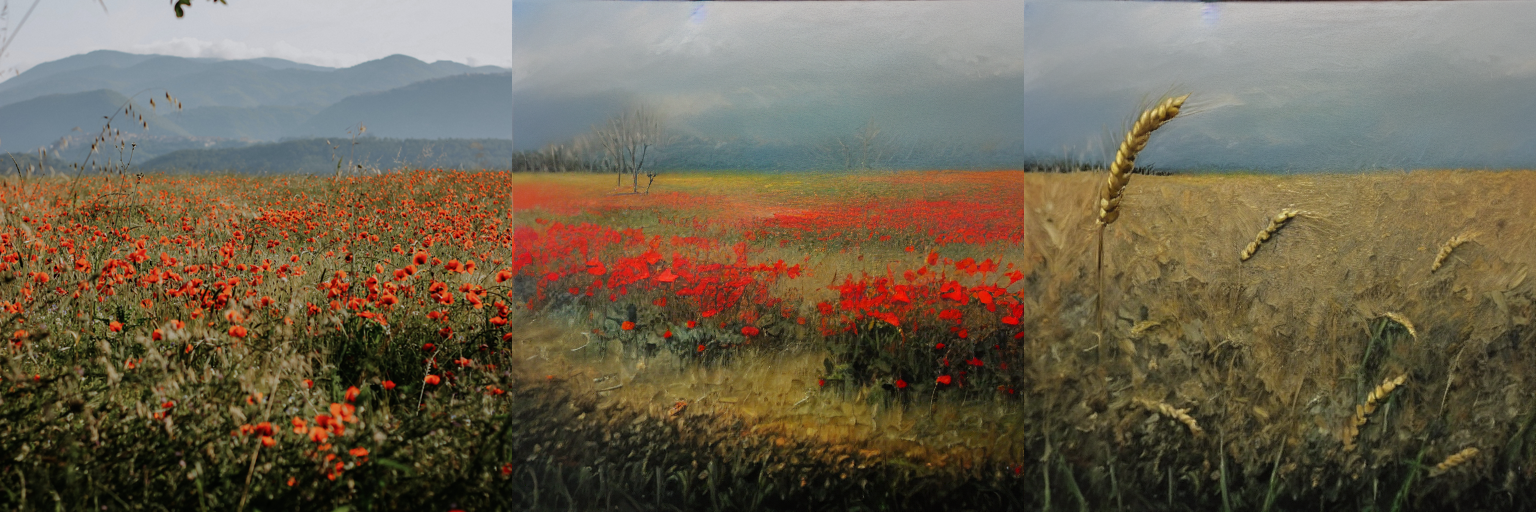

In [ ]:
display(show_reconstruction=True)